# Representation of linear symplectic flows using P-SympNets

In this notebook we will explore the representation property of P-SympNets. We will generate a data set from a linear symplectic transformation and train a number of P-SympNets to validate the theorem. 

In [1]:
import torch

torch.set_default_dtype(torch.float64)
torch.manual_seed(0)
device = None # torch.device('cuda' if torch.cuda.is_available() else 'cpu') if you have a GPU and doing large scale experiments. cpu (or None) is fine for small systems. 

## Generate a linear symplectic data set using the matrix exponential $exp(hJA)$

Where $J$ is the canonical sympelctic matrix, $A$ is a symmetric positive definite (i.e., non-degenerate) square matrix and $h$ is a small paramter (e.g., a time-step). 

The data set is in the form `x0`, `x1`, where `x0` are random initial conditions from the unit hypercube and `x1` are $exp(hJA)$ applied to `x0`. 

In [2]:
from linear_utils import generate_linear_hamiltonian_data, laplacian_matrix, separable_random_symmetric_matrix, dense_random_symmetric_matrix, canonical_symplectic_matrix, spectrum_adjoint_action
import numpy as np

DIM = 5
TIMESTEP = 0.01
NDATA = 50
MATRIX_TYPE = "random" # "random" for a symmetric random matrix or "laplacian" for a wave-like system

data_gen_kwargs = dict(
    dim=DIM, 
    ndata=NDATA, 
    timestep=TIMESTEP,
    device=device,
    method="matrix_exp",
)

if MATRIX_TYPE == "laplacian":
    A = laplacian_matrix(DIM) 
elif MATRIX_TYPE == "random":
    A = dense_random_symmetric_matrix(DIM)
elif MATRIX_TYPE == "separable":
    A = separable_random_symmetric_matrix(DIM)


x0_train, x1_train = generate_linear_hamiltonian_data(symmetric_matrix=A, **data_gen_kwargs)
x0_test, x1_test = generate_linear_hamiltonian_data(symmetric_matrix=A, **data_gen_kwargs)

print(f"Computing data for Hamiltonian system dx/dt = J*A*x where \n\nA = {np.round(A.detach().numpy(),2)}\n")
print(f"Rank(A) = {np.linalg.matrix_rank(A.detach().numpy())}")
print(f"min(spec(A)) = {torch.min(torch.linalg.eigvalsh(A))}")


Computing data for Hamiltonian system dx/dt = J*A*x where 

A = [[1.49 0.29 0.17 0.43 0.23 0.39 0.19 0.29 0.2  0.18]
 [0.29 1.09 0.26 0.31 0.13 0.17 0.11 0.25 0.27 0.41]
 [0.17 0.26 1.05 0.18 0.24 0.19 0.19 0.27 0.28 0.29]
 [0.43 0.31 0.18 1.08 0.21 0.48 0.39 0.3  0.24 0.1 ]
 [0.23 0.13 0.24 0.21 1.27 0.31 0.37 0.01 0.35 0.4 ]
 [0.39 0.17 0.19 0.48 0.31 1.18 0.18 0.25 0.13 0.19]
 [0.19 0.11 0.19 0.39 0.37 0.18 1.2  0.26 0.18 0.25]
 [0.29 0.25 0.27 0.3  0.01 0.25 0.26 1.08 0.22 0.08]
 [0.2  0.27 0.28 0.24 0.35 0.13 0.18 0.22 1.27 0.22]
 [0.18 0.41 0.29 0.1  0.4  0.19 0.25 0.08 0.22 1.31]]

Rank(A) = 10
min(spec(A)) = 0.4744150564539512


## Initialize quadratic P-SympNets and train on the dataset

Here we've implemented a very basic training function that uses the Adams optimiser to minimise the MSE loss. We use `joblib` to train 10 SympNets in parallel. We evaluate the trained SympNets on the test set and plot these errors against the number of Layers. 

The representation theorem for P-SympNets says that they should be able to learn the exact map $exp(hJA)$ when the number of layers equals the dimension of $A$, which is `layers = 2*DIM`. 

In [3]:
from linear_utils import train
import joblib
from strupnet.snn import SympNet

NEPOCHS = 2000
LEARNING_RATE = 0.05

def train_sympnet(layers):
    sympnet = SympNet(
        dim=DIM,
        min_degree=2,
        max_degree=2,
        layers=layers,
        method='P',
    )

    training_curve, best_train_loss = train(
        net=sympnet,
        x0=x0_train,
        x1=x1_train,
        lr=LEARNING_RATE,
        nepochs=NEPOCHS,
        timestep=TIMESTEP,
        tol=1e-15,
        use_best_train_loss=True, 
    )
    test_set_error = torch.mean((sympnet(x0_test, TIMESTEP) - x1_test)**2).item()
    return {"layers": layers, "best_loss": test_set_error}

# train 10 models in parallel using joblib 
n_jobs = 10
training_curves = joblib.Parallel(n_jobs=n_jobs)(
    joblib.delayed(train_sympnet)(layer) for layer in range(2*DIM-n_jobs//2, 2*DIM+n_jobs//2+1)
)

 20%|██        | 405/2000 [00:00<00:02, 734.73it/s, train_loss=7.13e-6, best_train_loss=7.13e-6, norm_grads=6.49e-15]]

Final loss value:  8.580578848476745e-16
Final loss value:  7.133052434202898e-06
Final loss value:  9.121849907313885e-16
Final loss value:  4.335191445689805e-06


 10%|█         | 201/2000 [00:00<00:03, 500.14it/s, train_loss=1.08e-13, best_train_loss=1.08e-13, norm_grads=1.03e-8]

Final loss value:  2.86952412322641e-06
Final loss value:  9.71615951453292e-16
Final loss value:  1.60205017512122e-06
Final loss value:  9.762202480572561e-16
Final loss value:  6.209983496263017e-07
Final loss value:  9.482120143554706e-16
Final loss value:  9.584208876846825e-16


 13%|█▎        | 255/2000 [00:00<00:03, 508.09it/s, train_loss=9.58e-16, best_train_loss=9.58e-16, norm_grads=7.9e-10] 


# Plot results

Here we see that when the number of layers is equal to or greater than the dimension of the matrix, the P-SympNet learns the exact flow. 

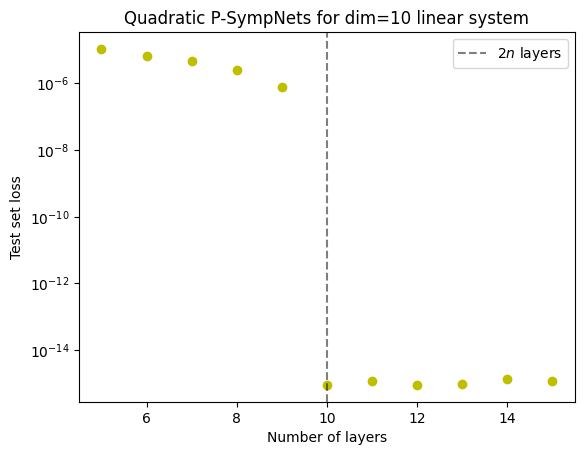

In [5]:
import matplotlib.pyplot as plt

for d in training_curves:
    plt.semilogy(d["layers"], d["best_loss"], 'yo')
# plot a vertical line at the optimal number of layers
plt.axvline(x=2*DIM, color='k', linestyle='--', alpha=0.5, label="$2n$ layers")
plt.xlabel("Number of layers")
plt.ylabel("Test set loss")
plt.title(f"Quadratic P-SympNets for dim={2*DIM} linear system")
plt.legend()
plt.show()
    